## 3. Sınıflandırma Problemleri

Sınıflandırma, bir veri kümesi (data set) birbirinden farklı ve önceden belirlenmiş sınıflardan birine atanmasıdır. Sınıflandırma algoritmaları, verilen eğitim kümesinden hangi veriyi hangi sınıfa atayacağını öğrenir. Daha sonra test verilerini doğru sınıflara atamaya çalışır.
Verilerin sınıflarını belirten değerlere etiket (label) denir.

##### Bu başlık altında ele alacağımız konular:
    • Lojistik Regresyon 
    • K-En Yakın Komşu (KNN) 
    • Yapay Sinir Ağları
    • Karar Ağaçları / Classification and Regression Trees (CART)
    • Random Forests
    • Gradient Boosting Machines (GBM)
    • XGBoost (Extreme Gradient Boosting)
    • Light GBM

## 3.1. Lojistik Regresyon

Temel amaç, sınıflandırma problemleri için bağımlı ve bağımsız değişkenler arasındaki ilişkiyi tanımlayan doğrusal bir model kurmaktır.
Bağımlı değişken burada kategoriktir.
Lojistik regresyon sonucu bir eşik değerinden geçirilerek karar verme işlemi gerçekleştirilir.
Lojistik fonksiyonu sayesinde üretilen değerler [0,1] arasında olur.

### 3.1.1. Model

In [1]:
# Kullanılacak tüm kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from skompiler import skompile
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from warnings import filterwarnings

In [50]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz. 

youtube = youtube.dropna()

In [51]:
# comments_disabled (yorumun devre dışı bırakılması alanı) kategorik olduğundan yani 0, 1 olarak nitelendirebildiğimizden o 
# alanı kullanmayı tercih ediyoruz.
youtube["comments_disabled"].value_counts()

False    38233
True       683
Name: comments_disabled, dtype: int64

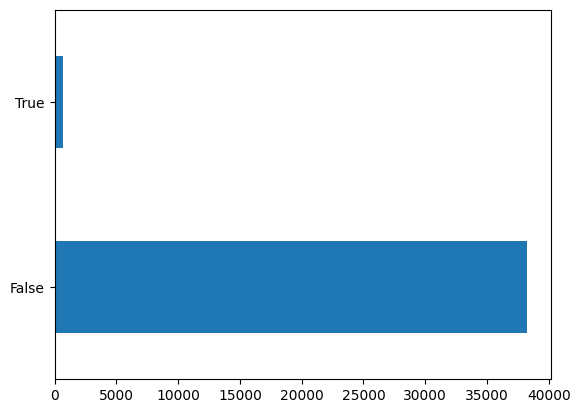

In [52]:
youtube["comments_disabled"].value_counts().plot.barh();

In [53]:
youtube.describe().T

,count,mean,std,min,25%,50%,75%,max
views,38916.0,5.911944e+06,1.900121e+07,851.0,251527.25,981889.0,3683628.50,424538912.0
likes,38916.0,1.345196e+05,3.499893e+05,0.0,5897.00,25182.5,114089.25,5613827.0
dislikes,38916.0,7.612560e+03,5.095683e+04,0.0,200.00,821.0,3357.50,1944971.0
comment_count,38916.0,1.308835e+04,5.066740e+04,0.0,679.00,2478.0,9241.50,1626501.0


In [54]:
filterwarnings('ignore')

y = youtube["comments_disabled"]
X = youtube.drop(["comments_disabled"], axis=1)

# statsmodels
loj = sm.Logit(y, X)
loj_model= loj.fit()
loj_model.summary()

         Current function value: 0.004081
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      comments_disabled   No. Observations:                38916
Model:                          Logit   Df Residuals:                    38912
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Jun 2023   Pseudo R-squ.:                  0.9538
Time:                        16:59:19   Log-Likelihood:                -158.81
converged:                      False   LL-Null:                       -3438.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
views          4.078e-06   7.02e-07      5.809      0.000     2.7e-06    5.45e-06
likes         -3.167e-05   2.73e-05     -1.162      0.245   -8.51e-05    2.18e-05
dislikes          0.0002      0.000      1.609      0.108   -4.95e-05       0.001
comment_count   -15.0086    147.251     -0.102      0.919    -303.616     273.599
=================================================================================

Possibly complete quasi-separation: A fraction 0.99 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [55]:
# scikit-learn
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X,y)
loj_model

LogisticRegression(solver='liblinear')

In [56]:
loj_model.intercept_ # lojistik regresyon modelinin kesme noktasına bakalım.

array([-0.00025238])

In [57]:
loj_model.coef_ # Modelin katsayılarını gösterir.

array([[ 7.12530217e-07, -1.89090766e-05,  3.07884988e-04,
        -3.14007830e-02]])

### 3.1.2. Tahmin & Model Tuning

Lojistik regresyon için girilebilecek bir hiperparametre olmadığından model tuning değil de model doğrulama yapacağız.

In [58]:
y_pred = loj_model.predict(X) # Veri kümesi X üzerinde sınıflandırma tahmini yapar.
confusion_matrix(y, y_pred)
# Karışıklık matrisi, sınıflandırma modelinin sınıfları ne kadar doğru veya yanlış sınıflandırdığını gösterir.

array([[38158,    75],
       [   12,   671]], dtype=int64)

In [59]:
accuracy_score(y, y_pred)# Gerçek sınıf değerleri (y) ve tahmin edilen sınıf değerleri (y_pred) arasındaki doğruluk skorunu hesaplamaktadır.

0.9977644156645081

In [60]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     38233
        True       0.90      0.98      0.94       683

    accuracy                           1.00     38916
   macro avg       0.95      0.99      0.97     38916
weighted avg       1.00      1.00      1.00     38916



#### Modele ilişkin olasılık değerleri

In [61]:
loj_model.predict(X)[0:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [62]:
y[0:10]

video_id
Jw1Y-zhQURU    False
3s1rvMFUweQ    False
n1WpP7iowLc    False
PUTEiSjKwJU    False
rHwDegptbI4    False
AumaWl0TNBo    False
2Vv-BfVoq4g    False
-N5eucPMTTc    False
LMCuKltaY3M    False
9t9u_yPEidY    False
Name: comments_disabled, dtype: bool

In [63]:
# Modele ilişkin olasılık değerleri. (İlk sütunun '0' ikinci sütunun '1' sınıfına ait olma olasılığı)
loj_model.predict_proba(X)[0:10]

array([[1.00000000e+000, 7.61209571e-127],
       [1.00000000e+000, 6.68402424e-038],
       [1.00000000e+000, 0.00000000e+000],
       [7.58084127e-001, 2.41915873e-001],
       [7.18135921e-001, 2.81864079e-001],
       [1.00000000e+000, 2.03629204e-032],
       [1.00000000e+000, 0.00000000e+000],
       [9.99999997e-001, 3.02042883e-009],
       [9.98515775e-001, 1.48422501e-003],
       [1.00000000e+000, 8.74926172e-154]])

#### Eşikleme işleminin el ile yapılması


In [64]:
y_probs = loj_model.predict_proba(X) # Model ile sınıf olasılıklarının tahmin edilmesi
y_probs = y_probs[:,1] # Yalnızca pozitif sınıfın olasılıkları elde edilmesi için

y_probs[0:10]

array([7.61209571e-127, 6.68402424e-038, 0.00000000e+000, 2.41915873e-001,
       2.81864079e-001, 2.03629204e-032, 0.00000000e+000, 3.02042883e-009,
       1.48422501e-003, 8.74926172e-154])

In [65]:
# Eşikleme işleminin el ile yapılması
y_pred = [1 if i > 0.5 else 0 for i in y_probs]

y_pred[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#### Raporlama

In [66]:
confusion_matrix(y, y_pred)

array([[38158,    75],
       [   12,   671]], dtype=int64)

In [67]:
accuracy_score(y, y_pred)

0.9977644156645081

In [68]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     38233
        True       0.90      0.98      0.94       683

    accuracy                           1.00     38916
   macro avg       0.95      0.99      0.97     38916
weighted avg       1.00      1.00      1.00     38916



In [69]:
loj_model.predict_proba(X)[:,1][0:5]

array([7.61209571e-127, 6.68402424e-038, 0.00000000e+000, 2.41915873e-001,
       2.81864079e-001])

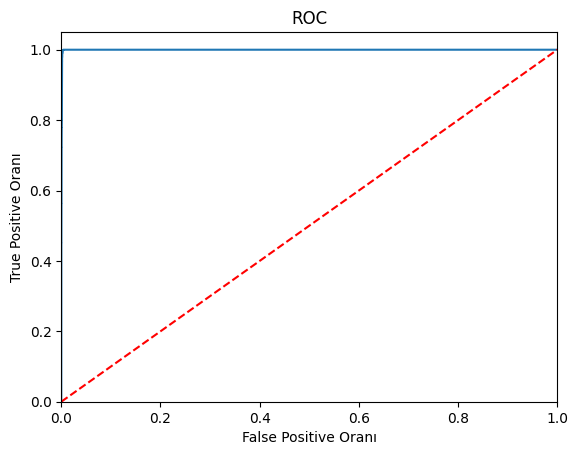

AUC= 0.9902343988595167


In [70]:
logit_roc_auc = roc_auc_score(y, loj_model.predict(X))
fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(X)[:,1])
plt.figure()

plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()
print("AUC=",logit_roc_auc)

In [71]:
# Test train ayırma işlemi
# Test setini 30% olarak ayarladık
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.30,
                                                    random_state = 42)

loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X_train,y_train)
loj_model

LogisticRegression(solver='liblinear')

In [72]:
accuracy_score(y_test, loj_model.predict(X_test))

0.9975160599571734

In [73]:
cross_val_score(loj_model, X_test, y_test, cv = 10) 
# Modelin test veri kümesi üzerinde çapraz doğrulama ile elde edilen doğruluk skorları listeler.

array([0.99828767, 1.        , 0.99657534, 0.99743151, 0.99743151,
       0.9982862 , 0.99742931, 0.99657241, 1.        , 0.99485861])

In [74]:
cross_val_score(loj_model, X_test, y_test, cv = 10).mean()
# Çapraz doğrulama ile elde edilen doğruluk skorlarının ortalamasını alır.

0.9976872556960241

## 3.2.  K-En Yakın Komşu (KNN)

KNN en basit anlamı ile içerisinde tahmin edilecek değerin bağımsız değişkenlerinin oluşturduğu vektörün en yakın komşularının hangi sınıfta yoğun olduğu bilgisi üzerinden sınıfını tahmin etmeye dayanır.

##### İşlem Adımları:
    1. Komşu sayısını belirle (k)
    2. Bilinmeyen nokta ile diğer tüm noktalar arasındaki uzaklıkları hesapla.
    3. Uzaklıkları sırala ve belirlenen k değerine göre en yakın k sayıda gözlemi seç.
    4. Sınıflandırma yapılıyorsa en sık karşılaşılan sınıf, regresyon yapılıyor ise ortalama değeri tahmin değeri olarak belirle.

### 3.2.1. Model

In [75]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [76]:
# Modelin oluşturulması ve eğitilmesi
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
knn_model

KNeighborsClassifier()

### 3.2.2 Tahmin

In [77]:
y_pred = knn_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.9840685224839401

In [78]:
filterwarnings('ignore')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     11464
        True       0.76      0.18      0.28       211

    accuracy                           0.98     11675
   macro avg       0.87      0.59      0.64     11675
weighted avg       0.98      0.98      0.98     11675



### 3.2.3 Model Tuning

In [79]:
knn_params = {"n_neighbors": np.arange(1,50)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [80]:
print("En iyi skor:" + str(knn_cv.best_score_))
print("En iyi parametreler: " + str(knn_cv.best_params_))

En iyi skor:0.984838998235191
En iyi parametreler: {'n_neighbors': 2}


In [81]:
knn = KNeighborsClassifier(2)
knn_tuned = knn.fit(X_train, y_train)

knn_tuned.score(X_test, y_test)

0.9841541755888651

In [82]:
y_pred = knn_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

0.9841541755888651

## 3.3. Yapay Sinir Ağları

Yapay sinir ağları, insan beyninin bilgi işleme tekniğinden esinlenerek geliştirilmiş bir bilgi işlem teknolojisidir. YSA ile basit biyolojik sinir sisteminin çalışma şekli taklit edilir. Yani biyolojik nöron hücrelerinin ve bu hücrelerin birbirleri ile arasında kurduğu sinaptik bağın dijital olarak modellenmesidir.

### 3.3.1. Model

In [2]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube=youtube.sample(n=500)

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [3]:
scaler = StandardScaler() # Veriyi önce standardizasyona sokup ardından yapay sinir ağlarını yapmalıyız.
# Veri standardizasyonu
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
X_test_scaled[0:5]

array([[ 0.65975193,  1.26158809,  0.23926794,  0.98881589],
       [-0.07115165,  0.15088737, -0.21637381, -0.01698781],
       [-0.29383548, -0.38755334, -0.32872675, -0.34139154],
       [-0.22699345, -0.06479808, -0.14321128,  0.09304199],
       [-0.06228166, -0.23955388, -0.12137966, -0.0846153 ]])

In [5]:
filterwarnings('ignore')

mlpc = MLPClassifier().fit(X_train_scaled, y_train)

### 3.3.2 Tahmin

In [6]:
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9933333333333333

### 3.3.3 Model Tuning

In [7]:
mlpc

MLPClassifier()

In [8]:
# Cross validation işlemi
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}


mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005, 0.0001, 1e-05],
                         'hidden_layer_sizes': [(10, 10, 10), (100, 100, 100),
                                                (100, 100), (3, 5), (5, 3)],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             verbose=2)

In [9]:
print("En iyi parametreler: " + str(mlpc_cv_model.best_params_))

En iyi parametreler: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'lbfgs'}


In [10]:
# En iyi parametrelerin modele uygulanması
mlpc_tuned = MLPClassifier(activation = "relu",
                        alpha = 0.01,
                        hidden_layer_sizes = (10, 10, 10),
                        solver = "lbfgs")

In [11]:
mlpc_tuned.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(10, 10, 10), solver='lbfgs')

In [12]:
y_pred = mlpc_tuned.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9933333333333333

## 3.4 Karar Ağaçları / Classification and Regression Trees (CART)

Temel amaç veriseti içerisindeki karmaşık yapıları basit karar yapılarına dönüştürmektir. Heterojen verisetleri belirlenmiş bir hedef değişkene göre homojen alt gruplara ayrılır.

### 3.4.1. Model

In [83]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [84]:
# Karar ağaçları yöntemiyle modelin oluşturulup fit edilmesi.
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)

### 3.4.2. Tahmin

In [85]:
cart_model

DecisionTreeClassifier()

In [53]:
# Modelin Python koduna dünüştürülmesi
print(skompile(cart_model.predict).to("python/code"))

(((0 if x[1] <= 25.5 else 1 if x[0] <= 2794.0 else 0) if x[0] <= 7129.5 else
    (((1 if x[1] <= 661.5 else 0 if x[0] <= 51487.5 else 1) if x[0] <= 
    117359.0 else 1 if x[1] <= 61.0 else 0) if x[0] <= 144654.0 else 1 if x
    [2] <= 338.0 else 0) if x[0] <= 158631.0 else ((1 if x[0] <= 370687.5 else
    0) if x[0] <= 375160.0 else 1) if x[1] <= 27817.5 else 0 if x[1] <= 
    28350.0 else (1 if x[1] <= 30653.5 else 0 if x[2] <= 3927.5 else 1 if x
    [1] <= 31865.0 else 1) if x[1] <= 32067.5 else 1) if x[3] <= 0.5 else 0)



In [86]:
x = [6,148,72,35,0,33.6,0.627,50]

In [87]:
(((0 if x[1] <= 25.5 else 1 if x[2] <= 1.0 else 0) if x[0] <= 7129.5 else (
    ((1 if x[1] <= 661.5 else 0 if x[0] <= 51487.5 else 1) if x[0] <= 
    117359.0 else 1 if x[2] <= 122.0 else 0) if x[0] <= 144654.0 else 0 if 
    x[1] <= 3894.5 else 1) if x[0] <= 158631.0 else ((1 if x[0] <= 370687.5
     else 0) if x[0] <= 375160.0 else 1) if x[1] <= 27817.5 else 0 if x[1] <=
    28350.0 else (1 if x[1] <= 30653.5 else 0 if x[1] <= 31137.0 else 1 if 
    x[0] <= 1820391.0 else 1) if x[1] <= 32067.5 else 1) if x[3] <= 0.5 else 0)
  

0

In [88]:
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9994004282655247

### 3.4.3. Model Tuning

In [89]:
cart_model

DecisionTreeClassifier()

In [90]:
# Çapraz doğrulama işlemi
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


In [91]:
# Çapraz doğrulama sonucu en iyi parametrelerin belirlenmesi
print("En iyi parametreler: " + str(cart_cv_model.best_params_))

En iyi parametreler: {'max_depth': 7, 'min_samples_split': 10}


In [92]:
cart = tree.DecisionTreeClassifier(max_depth = 7, min_samples_split = 10)# En iyi parametreleri model üzerinde uyguladık.
cart_tuned = cart.fit(X_train, y_train)

y_pred = cart_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.9992291220556745

## 3.5. Random Forests

Temeli birden çok karar ağacının ürettiği tahminlerin bir araya getirilerek değerlendirilmesidir.

- Bagging (Breiman, 1996) ile Random Subspace (Ho, 1998) yöntemlerinin birleşimi ile oluşmuştur.
- Ağaçlar için gözlemler bootstrap rastgele örnek seçim yöntemi ile değişkenler random subspace yöntemi ile seçilir.
- Karar ağacının her bir düğümünde en iyi dallara ayırıcı (bilgi kazancı) değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişken arasından seçilir.
- Ağaç oluşturmada veri setinin 2/3'ü kullanılır. Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin
belirlenmesi için kullanılır.
- Her düğüm noktasında rastgele değişken seçimi yapılır. (regresyon'da p/3, sınıflama'da karekök p)
- Nihai tahmin için ağaçlardan tahmin değerleri talep edilirken her bir ağacın daha önce hesaplanan hata oranları göz önüne alınarak ağaçlara ağırlık verilir.
#####

### 3.5.1. Model

In [96]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube=youtube.sample(n=500) # Veri seti üzerindeki 500 kaydı veri seti üzerinde çalışma süresini azaltabilmek için 
                               # örneklem olarak alıyoruz. 

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [97]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

### 3.5.2. Tahmin

In [98]:
y_pred = rf_model.predict(X_test) # Model üzerinde sınıflandırma tahminleri yapar.
accuracy_score(y_test, y_pred) # Gerçek sınıf değerleri ile tahmin edilen sınıf değerleri arasındaki doğruluk skorunu hesaplar.

1.0

Doğruluk skoru 1 çıktı. Yani gerçek sınıf değerleri ile tahmin edilen sınıf değerleri aynıdır kanısına varabiliriz.

### 3.5.3. Model Tuning

In [99]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

In [100]:
rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 10], 'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=2)

In [101]:
print("En iyi parametreler: " + str(rf_cv_model.best_params_))

En iyi parametreler: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [102]:
# En iyi parametrelerin uygulanması ve sonra fit edilmesi.
rf_tuned = RandomForestClassifier(max_depth = 2,
                                max_features = 2,
                                min_samples_split = 2,
                                n_estimators = 500)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=2, n_estimators=500)

In [103]:
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

Text(0.5, 0, 'Değişken Önem Düzeyleri')

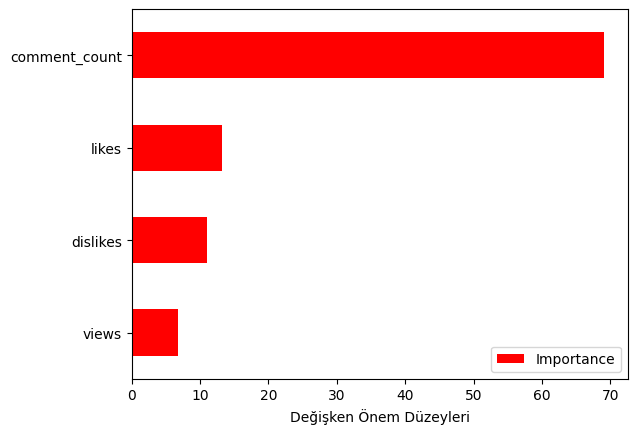

In [104]:
# Değişkenlerin önem düzeylerine grafik üzerinde bakalım.
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                            index = X_train.columns)

Importance.sort_values(by = "Importance",
                        axis = 0,
                        ascending = True).plot(kind ="barh", color = "r")
plt.xlabel("Değişken Önem Düzeyleri")

## 3.6. Gradient Boosting Machines (GBM)

AdaBoost'un sınıflandırma ve regresyon problemlerine kolayca uyarlanabilen genellenmiş bir versiyonudur.
Adaptive Boosting (AdaBoost) zayıf sınıflandırıcıların bir araya gelerek güçlü bir sınıflandırıcı oluşturması için geliştirilen bir yöntemdir.

##### • Gradient boosting tek bir tahminsel model formunda olan modeller serisi oluşturur.
##### • Seri içerisindeki bir model serideki bir önceki modelin tahmin artıklarının/hatalarının (residuals) üzerine kurularak (fit) oluşturulur.
##### • GBM diferansiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient Descent algoritmasını kullanmaktadır.
##### • GB bir çok temel öğrenici tipi (base learner type) kullanabilir. (Trees, linear terms, splines,...)
##### • Cost fonksiyonları ve link fonksiyonları modifiye edilebilirdir.
##### • Boosting + Gradient Descent

### 3.6.1. Model

In [108]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube=youtube.sample(n=500) # Veri seti üzerindeki 500 kaydı veri seti üzerinde çalışma süresini azaltabilmek için 
                               # örneklem olarak alıyoruz. 

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [109]:
# Modelin oluşturulması ve fit ile eğitme işlemi
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)

### 3.6.2. Tahmin

In [110]:
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9933333333333333

### 3.6.3. Model Tuning

In [111]:
# GridSearchCV ile cross validation işlemi yapılarak optimum değerlerin belirlenmesi.
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
            "n_estimators": [100,500,100],
            "max_depth": [3,5,10],
            "min_samples_split": [2,5,10]}

gbm = GradientBoostingClassifier()
gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [112]:
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 100]},
             verbose=2)

In [113]:
print("En iyi parametreler: " + str(gbm_cv.best_params_))

En iyi parametreler: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [114]:
# En iyi parametreleri uygulayarak modeli fit edelim.
gbm = GradientBoostingClassifier(learning_rate = 0.01,
                                max_depth = 3,
                                min_samples_split = 2,
                                n_estimators = 100)

gbm_tuned = gbm.fit(X_train,y_train)

In [115]:
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)# Doğruluk skoru

0.9933333333333333

### 3.7. XGBoost (eXtreme Gradient Boosting)

##### XGBoost, GBM'in hız ve tahmin performansını arttırmak üzere optimize edilmiş; ölçeklenebilir ve farklı platformlara entegre edilebilir halidir.
      - R, Python, Hadoop, Scala, Julia ile kullanılabilir.
      - Ölçeklenebilir.
      - Hızlı.
      - Tahmin başarısı yüksek.
      - Birçok kaggle yarışmasında başarısını kanıtlamış.

### 3.7.1. Model

In [116]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube=youtube.sample(n=500) # Veri seti üzerindeki 500 kaydı veri seti üzerinde çalışma süresini azaltabilmek için 
                               # örneklem olarak alıyoruz. 

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [117]:
xgb_model = XGBClassifier().fit(X_train, y_train)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### 3.7.2. Tahmin

In [118]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

### 3.7.3. Model Tuning

In [119]:
xgb_params = {
            'n_estimators': [100, 500, 1000, 2000],
            'subsample': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5,6],
            'learning_rate': [0.1,0.01,0.02,0.05],
            "min_samples_split": [2,5,10]}

xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

In [120]:
xgb_cv_model.fit(X_train, y_train)# Cross validation sonucu oluşan modelin fit edilmesi

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
[17:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000, 2000],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [121]:
xgb_cv_model.best_params_ # Cross validation sonucu en iyi parametrelerin belirlenmesi.

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.6}

In [122]:
# Optimum değerleri modelimizi uygulayalım.
xgb = XGBClassifier(learning_rate = 0.1,
                    max_depth = 3,
                    min_samples_split = 2,
                    n_estimators = 100,
                    subsample = 0.6)

xgb_tuned = xgb.fit(X_train,y_train)

[17:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



In [123]:
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

## 3.8. Light GBM

###### Light GBM, XGBoost'un eğitim süresini azaltmaya yönelik geliştirilmiş bir diğer GBM türüdür.

##### 2017 yılında Microsoft tarafından geliştirilmiştir.
      - Daha performanslıdır.
      - Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisi kullanır.
      - Breadth-first search (BSF) yerine depth-first search (DFS) arama algoritmasını kullanır.

### 3.8.1. Model

In [124]:
df=pd.read_csv("dataset/youtubeGB.csv")
youtube=df.copy()

youtube.index = youtube.iloc[:,0] # video_id'lerini index olarak belirttik.

youtube1=youtube["comments_disabled"]
youtube2=youtube.iloc[:,7:11] # Alanlardan views, likes, dislikes ve comment_count seçtik.
    
youtube=pd.concat([youtube1,youtube2],axis=1) # İki dataframe'i birleştiriyoruz.

youtube=youtube.sample(n=500) # Veri seti üzerindeki 500 kaydı veri seti üzerinde çalışma süresini azaltabilmek için 
                               # örneklem olarak alıyoruz. 

youtube = youtube.dropna()
y = youtube["comments_disabled"]
X = youtube.drop(['comments_disabled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [125]:
lgbm_model = LGBMClassifier().fit(X_train, y_train) # Modelin oluşturulması, fit edilmesi

### 3.8.2. Tahmin

In [126]:
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

### 3.8.3. Model Tuning

In [127]:
lgbm_params = {
            'n_estimators': [100, 500, 1000, 2000],
            'subsample': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5,6],
            'learning_rate': [0.1,0.01,0.02,0.05],
            "min_child_samples": [5,10,20]}

lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params,
                        cv = 10,
                        n_jobs = -1,
                        verbose = 2)

In [128]:
lgbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


GridSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_samples': [5, 10, 20],
                         'n_estimators': [100, 500, 1000, 2000],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [129]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 5,
 'n_estimators': 100,
 'subsample': 0.6}

In [130]:
# En iyi parametreleri uygularak modeli fit edelim.
lgbm = LGBMClassifier(learning_rate = 0.1,
                    max_depth = 3,
                    subsample = 0.6,
                    n_estimators = 100,
                    min_child_samples = 5)

lgbm_tuned = lgbm.fit(X_train,y_train)

y_pred = lgbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

## 3.9. Modellerin Karşılaştırılması

In [131]:
# Tüm modelleri karşılaştıralım.
modeller = [
    loj_model,
    knn_tuned,
    mlpc_tuned,
    cart_tuned,
    rf_tuned,
    gbm_tuned,
    xgb_tuned,
    lgbm_tuned
]

for model in modeller:
    if(model!=mlpc_tuned):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    isimler = model.__class__.__name__
    print("-"*30)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))

------------------------------
LogisticRegression:
Accuracy: 100.0000%
------------------------------
KNeighborsClassifier:
Accuracy: 100.0000%
------------------------------
MLPClassifier:
Accuracy: 100.0000%
------------------------------
DecisionTreeClassifier:
Accuracy: 100.0000%
------------------------------
RandomForestClassifier:
Accuracy: 100.0000%
------------------------------
GradientBoostingClassifier:
Accuracy: 99.3333%
------------------------------
XGBClassifier:
Accuracy: 100.0000%
------------------------------
LGBMClassifier:
Accuracy: 100.0000%


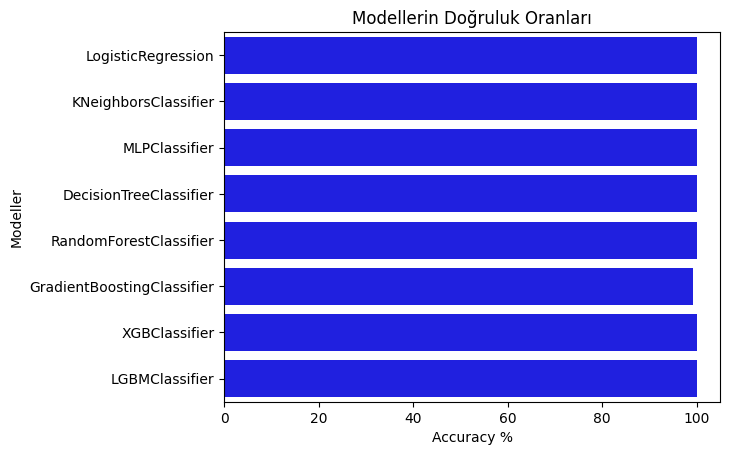

In [132]:
filterwarnings('ignore')

sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    if(model!=mlpc_tuned):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
        
    dogruluk = accuracy_score(y_test, y_pred)

    isimler = model.__class__.__name__
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)

# Sonuçları grafik üzerinde görelim.    
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="b")
plt.xlabel('Accuracy %')
plt.title('Modellerin Doğruluk Oranları');

Yukarıdaki grafikte modellerin sonuçlarını görmekteyiz. Bazı modellerin doğruluk oranları neredeyse aynı sonuç vermiştir. Birçok model %100 civarı sonuç verirken  GradientBoostingClassifier modeli de %99 civarı sonuç verdiği gözlemlenmektedir. (Bazı algoritmalarda çalışma süresi çok uzun olduğu için sadece ilk 500 veri örneklem alınarak kullanılmıştır.)